# Lab 5: Spam Detection

**Deadline**: Monday, Nov 15, 5:00 PM

**Late Penalty**: Any work that is submitted between 0 hour and 24 hours past the deadline will receive a 20% grade deduction. No other late work is accepted. Quercus submission time will be used, not your local computer time. You can submit your labs as many times as you want before the deadline, so please submit often and early.

**TA**: Saba Ale Ebrahim <saba.aleebrahim@mail.utoronto.ca>

In this assignment, we will build a recurrent neural network to classify a SMS text message
as "spam" or "not spam". In the process, you will
    
1. Clean and process text data for machine learning.
2. Understand and implement a character-level recurrent neural network.
3. Use torchtext to build recurrent neural network models.
4. Understand batching for a recurrent neural network, and use torchtext to implement RNN batching.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up. You can produce a PDF of your Google Colab file by going to File > Print and then save as PDF. The Colab instructions have more information (.html files are also acceptable).

Do not submit any other files produced by your code.

Include a link to your colab file in your submission.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

Colab Link: https://drive.google.com/file/d/1vaCDYDOwWPB5_Vv02Y56O_ftywRgIxSV/view?usp=sharing

In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt 

## Part 1. Data Cleaning [15 pt]

We will be using the "SMS Spam Collection Data Set" available at http://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection

There is a link to download the "Data Folder" at the very top of the webpage. Download the zip file, unzip it, and upload the file `SMSSpamCollection` to Colab.    

### Part (a) [2 pt]

Open up the file in Python, and print out one example of a spam SMS, and one example of a non-spam SMS.

What is the label value for a spam message, and what is the label value for a non-spam message?

In [4]:
for line in open('SMSSpamCollection'):
    break

ham = True
for line in open('SMSSpamCollection'):
    if "ham" in line and ham:
      print("ham: ", line)
      ham = False
    elif "spam" in line and not ham:
      print("spam: ", line)
      break

ham:  ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...

spam:  spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's



### Part (b) [1 pt]

How many spam messages are there in the data set?
How many non-spam messages are there in the data set?


In [5]:
count_ham = 0
count_spam = 0

for line in open('SMSSpamCollection'):
  if "spam" in line:
    count_spam += 1
  else:
    count_ham += 1

print("# spam messages:", count_spam)
print("# non-spam messages:", count_ham)

# spam messages: 747
# non-spam messages: 4827


### Part (c) [4 pt]

We will be using the package `torchtext` to load, process, and batch the data.
A tutorial to torchtext is available below. This tutorial uses the same
Sentiment140 data set that we explored during lecture.

https://medium.com/@sonicboom8/sentiment-analysis-torchtext-55fb57b1fab8

Unlike what we did during lecture, we will be building a **character level RNN**.
That is, we will treat each **character** as a token in our sequence,
rather than each **word**.

Identify two advantage and two disadvantage of modelling SMS text
messages as a sequence of characters rather than a sequence of words.

In [6]:
# Advantages: 
# 1. Require less memory. 
# 2. Character-base is compatible with spelling errors.


# Disadvantages: 
# 1. Takes more time to train because character-base requires larger hidden layers.
# 2. The accuracy is lower than word-based.

### Part (d) [1 pt]

We will be loading our data set using `torchtext.data.TabularDataset`. The
constructor will read directly from the `SMSSpamCollection` file. 

For the data file to be read successfuly, we
need to specify the **fields** (columns) in the file. 
In our case, the dataset has two fields: 

- a text field containing the sms messages,
- a label field which will be converted into a binary label.

Split the dataset into `train`, `valid`, and `test`. Use a 60-20-20 split.
You may find this torchtext API page helpful:
https://torchtext.readthedocs.io/en/latest/data.html#dataset

Hint: There is a `Dataset` method that can perform the random split for you.

In [15]:
import torchtext
from torchtext.legacy import data

text_field = torchtext.legacy.data.Field(sequential=True,      # text sequence
                                  tokenize=lambda x: x, # because are building a character-RNN
                                  include_lengths=True, # to track the length of sequences, for batching
                                  batch_first=True,
                                  use_vocab=True)       # to turn each character into an integer index
label_field = torchtext.legacy.data.Field(sequential=False,    # not a sequence
                                   use_vocab=False,     # don't need to track vocabulary
                                   is_target=True,      
                                   batch_first=True,
                                   preprocessing=lambda x: int(x == 'spam')) # convert text to 0 and 1

fields = [('label', label_field), ('sms', text_field)]
dataset = torchtext.legacy.data.TabularDataset("SMSSpamCollection", # name of the file
                                        "tsv",               # fields are separated by a tab
                                        fields)

# dataset[0].sms
# dataset[0].label
# train, valid, test = ...
train, valid, test = dataset.split([0.6, 0.2, 0.2], True)
print(len(train))
print(len(valid))
print(len(test))

3343
1115
1114


### Part (e) [2 pt]

You saw in part (b) that there are many more non-spam messages than spam messages.
This **imbalance** in our training data will be problematic for training.
We can fix this disparity by duplicating spam messages in the training set,
so that the training set is roughly **balanced**.

Explain why having a balanced training set is helpful for training our neural network.

Note: if you are not sure, try removing the below code and train your mode.

In [16]:
# save the original training examples
old_train_examples = train.examples
# get all the spam messages in `train`
train_spam = []
for item in train.examples:
    if item.label == 1:
        train_spam.append(item)
# duplicate each spam message 6 more times
train.examples = old_train_examples + train_spam * 6

print(len(train.examples))

# Explain:
# Since the binary classification algorithm is based on the majority rule,
# we want to balance the sample number for spam and ham.
# Otherwise, the trining weights would be lean to ham messages,
# causing poor accuracy of our model.

6031


### Part (f) [1 pt]

We need to build the vocabulary on the training data by running the below code.
This finds all the possible character tokens in the training set.

Explain what the variables `text_field.vocab.stoi` and `text_field.vocab.itos` represent.

In [17]:
text_field.build_vocab(train)
print(text_field.vocab.stoi)
print(text_field.vocab.itos)

# Explain: 
# text_field.vocab.stoi: a dictionary that maps token strings to integers.
# text_field.vocab.itos: a list of characters indexed by integers that has same order as stoi.

defaultdict(<bound method Vocab._default_unk_index of <torchtext.legacy.vocab.Vocab object at 0x7f33ccfe4c10>>, {'<unk>': 0, '<pad>': 1, ' ': 2, 'e': 3, 'o': 4, 't': 5, 'a': 6, 'n': 7, 'r': 8, 'i': 9, 's': 10, 'l': 11, 'u': 12, 'h': 13, '0': 14, 'd': 15, '.': 16, 'c': 17, 'm': 18, 'y': 19, 'w': 20, 'p': 21, 'g': 22, '1': 23, 'f': 24, '2': 25, 'T': 26, 'b': 27, 'k': 28, '8': 29, 'E': 30, 'v': 31, '5': 32, 'S': 33, 'O': 34, 'I': 35, 'C': 36, 'N': 37, '4': 38, 'A': 39, 'x': 40, '7': 41, '3': 42, 'R': 43, '6': 44, '!': 45, '9': 46, ',': 47, 'P': 48, 'W': 49, 'U': 50, 'L': 51, 'M': 52, 'H': 53, 'G': 54, 'D': 55, 'B': 56, 'Y': 57, 'F': 58, '/': 59, "'": 60, '?': 61, '£': 62, '&': 63, 'X': 64, '-': 65, ':': 66, 'z': 67, 'V': 68, 'K': 69, 'j': 70, '*': 71, 'J': 72, ')': 73, ';': 74, '+': 75, 'q': 76, '(': 77, 'Q': 78, '#': 79, '"': 80, '>': 81, '@': 82, 'ü': 83, 'Z': 84, '=': 85, 'Ü': 86, '$': 87, '<': 88, '|': 89, '%': 90, '‘': 91, '_': 92, '\x92': 93, '¡': 94, '…': 95, '[': 96, ']': 97, '–':

### Part (g) [2 pt]

The tokens `<unk>` and `<pad>` were not in our SMS text messages.
What do these two values represent?

In [18]:
# <unk>: unknown tokens
# <pad>: padding



### Part (h) [2 pt]

Since text sequences are of variable length, `torchtext` provides a `BucketIterator` data loader,
which batches similar length sequences together. The iterator also provides functionalities to
pad sequences automatically.

Take a look at 10 batches in `train_iter`. What is the maximum length of the
input sequence in each batch? How many `<pad>` tokens are used in each of the 10
batches?

In [20]:
train_iter = torchtext.legacy.data.BucketIterator(train,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

In [21]:
count = 1
for batch in train_iter:
  if(count<10):
    print("Batch number:", count)
    print("max length:", int(batch.sms[1][0]))
    sum = 0
    for msg in range(len(batch.sms[1])):
      sum += int(batch.sms[1][0] - batch.sms[1][msg])
    print("# of <pad> tokens used:", sum)
    count += 1

Batch number: 1
max length: 159
# of <pad> tokens used: 0
Batch number: 2
max length: 95
# of <pad> tokens used: 46
Batch number: 3
max length: 89
# of <pad> tokens used: 88
Batch number: 4
max length: 146
# of <pad> tokens used: 19
Batch number: 5
max length: 69
# of <pad> tokens used: 29
Batch number: 6
max length: 160
# of <pad> tokens used: 5
Batch number: 7
max length: 57
# of <pad> tokens used: 49
Batch number: 8
max length: 82
# of <pad> tokens used: 47
Batch number: 9
max length: 76
# of <pad> tokens used: 45


## Part 2. Model Building [8 pt]

Build a recurrent neural network model, using an architecture of your choosing. 
Use the one-hot embedding of each character as input to your recurrent network.
Use one or more fully-connected layers to make the prediction based on your
recurrent network output.

Instead of using the RNN output value for the final token, another often used
strategy is to max-pool over the entire output array. That is, instead of calling
something like:

```
out, _ = self.rnn(x)
self.fc(out[:, -1, :])
```

where `self.rnn` is an `nn.RNN`, `nn.GRU`, or `nn.LSTM` module, and `self.fc` is a 
fully-connected 
layer, we use:

```
out, _ = self.rnn(x)
self.fc(torch.max(out, dim=1)[0])
```

This works reasonably in practice. An even better alternative is to concatenate the
max-pooling and average-pooling of the RNN outputs:

```
out, _ = self.rnn(x)
out = torch.cat([torch.max(out, dim=1)[0], 
                 torch.mean(out, dim=1)], dim=1)
self.fc(out)
```

We encourage you to try out all these options. The way you pool the RNN outputs
is one of the "hyperparameters" that you can choose to tune later on.

In [22]:
# You might find this code helpful for obtaining
# PyTorch one-hot vectors.

ident = torch.eye(10)
print(ident[0]) # one-hot vector
print(ident[1]) # one-hot vector
x = torch.tensor([[1, 2], [3, 4]])
print(ident[x]) # one-hot vectors

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]]])


In [23]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        self.name = "RNN"
        super(RNN, self).__init__()
        self.emb = torch.eye(len(text_field.vocab.itos))
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # Look up the embedding
        x = self.emb[x]
        # Set an initial hidden state
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        # Forward propagate the RNN
        out, _ = self.rnn(x, h0)
        # Pass the output of the last time step to the classifier
        out = self.fc(out[:, -1, :])
        return out

## Part 3. Training [16 pt]

### Part (a) [4 pt]

Complete the `get_accuracy` function, which will compute the
accuracy (rate) of your model across a dataset (e.g. validation set).
You may modify `torchtext.data.BucketIterator` to make your computation
faster.

In [31]:
def get_accuracy(model, batch_size, data):
    """ Compute the accuracy of the `model` across a dataset `data`
    
    Example usage:
    
    >>> model = MyRNN() # to be defined
    >>> get_accuracy(model, valid) # the variable `valid` is from above
    """
    data_loader = torchtext.legacy.data.BucketIterator(data,
                                           batch_size=batch_size,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

    correct, total = 0, 0
    for message, labels in data_loader:
        output = model(message[0])
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += labels.shape[0]
    return correct / total

### Part (b) [4 pt]

Train your model. Plot the training curve of your final model. 
Your training curve should have the training/validation loss and
accuracy plotted periodically.

Note: Not all of your batches will have the same batch size.
In particular, if your training set does not divide evenly by
your batch size, there will be a batch that is smaller than
the rest. 

In [27]:
def train_rnn_network(model, train, valid, batch_size, num_epochs=5, learning_rate=1e-5):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    train_losses, val_losses,train_acc, valid_acc = [], [], [], []
    epochs = []
    train_loader = torchtext.legacy.data.BucketIterator(train,
                                           batch_size=batch_size,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs
    valid_loader = torchtext.legacy.data.BucketIterator(valid,
                                           batch_size=batch_size,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs
    for epoch in range(num_epochs):
        for message, labels in train_loader:
            optimizer.zero_grad()
            pred = model(message[0])
            loss = criterion(pred, labels)
            loss.backward()
            optimizer.step()
        train_losses.append(float(loss))

        for message, labels in valid_loader:
            optimizer.zero_grad()
            pred = model(message[0])
            loss = criterion(pred, labels)
            loss.backward()
            optimizer.step()
        val_losses.append(float(loss))

        epochs.append(epoch)
        train_acc.append(get_accuracy(model, batch_size,train))
        valid_acc.append(get_accuracy(model, batch_size,valid))
        print("Epoch %d; Loss %f; Train Acc %f; Val Acc %f" % (
              epoch+1, loss, train_acc[-1], valid_acc[-1]))
        model_path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(model.name, batch_size, learning_rate, epoch)
        torch.save(model.state_dict(), model_path)
    # plotting
    plt.title("Training Curve")
    plt.plot(train_losses, label="Train")
    plt.plot(val_losses, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, valid_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()
    print("Training Accuracy: {}".format(train_acc[-1]))
    print("Validation Accuracy: {}".format(valid_acc[-1]))

Epoch 1; Loss 0.641772; Train Acc 0.499585; Val Acc 0.865471
Epoch 2; Loss 0.504606; Train Acc 0.490300; Val Acc 0.866368
Epoch 3; Loss 0.264246; Train Acc 0.633228; Val Acc 0.885202
Epoch 4; Loss 0.395056; Train Acc 0.865362; Val Acc 0.919283
Epoch 5; Loss 0.433042; Train Acc 0.883270; Val Acc 0.933632
Epoch 6; Loss 0.058400; Train Acc 0.902172; Val Acc 0.944395
Epoch 7; Loss 0.272503; Train Acc 0.914276; Val Acc 0.952466
Epoch 8; Loss 0.235964; Train Acc 0.914276; Val Acc 0.956054
Epoch 9; Loss 0.138764; Train Acc 0.927209; Val Acc 0.956054
Epoch 10; Loss 0.208496; Train Acc 0.920577; Val Acc 0.954260


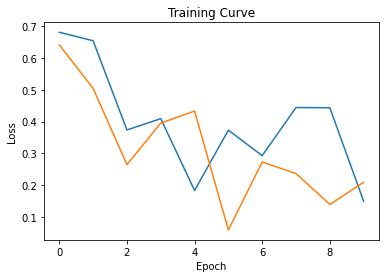

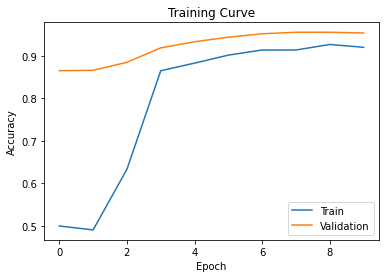

Training Accuracy: 0.920577018736528
Validation Accuracy: 0.9542600896860987


In [34]:
model = RNN(len(text_field.vocab.itos), 100, 2)
train_rnn_network(model, train, valid, batch_size = 32, num_epochs = 10, learning_rate = 5e-5)

### Part (c) [4 pt]

Choose at least 4 hyperparameters to tune. Explain how you tuned the hyperparameters.
You don't need to include your training curve for every model you trained.
Instead, explain what hyperparemters you tuned, what the best validation accuracy was,
and the reasoning behind the hyperparameter decisions you made.

For this assignment, you should tune more than just your learning rate and epoch. 
Choose at least 2 hyperparameters that are unrelated to the optimizer.

Epoch 1; Loss 0.694005; Train Acc 0.480020; Val Acc 0.865471
Epoch 2; Loss 0.635500; Train Acc 0.480020; Val Acc 0.865471
Epoch 3; Loss 0.570714; Train Acc 0.486818; Val Acc 0.865471
Epoch 4; Loss 0.543299; Train Acc 0.514177; Val Acc 0.866368
Epoch 5; Loss 0.404752; Train Acc 0.625933; Val Acc 0.877130
Epoch 6; Loss 0.337213; Train Acc 0.865362; Val Acc 0.911211
Epoch 7; Loss 0.187077; Train Acc 0.862046; Val Acc 0.912108
Epoch 8; Loss 1.616979; Train Acc 0.896866; Val Acc 0.923767
Epoch 9; Loss 0.244778; Train Acc 0.893218; Val Acc 0.917489
Epoch 10; Loss 0.086960; Train Acc 0.897032; Val Acc 0.922870


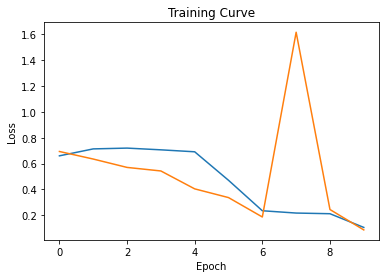

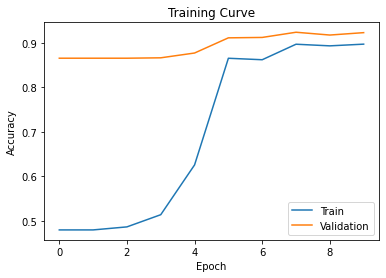

Training Accuracy: 0.8970320013264799
Validation Accuracy: 0.9228699551569507


In [35]:
# 1
model = RNN(len(text_field.vocab.itos), 100, 2)
train_rnn_network(model, train, valid, batch_size = 64, num_epochs = 10, learning_rate = 5e-5)

Epoch 1; Loss 0.582253; Train Acc 0.508705; Val Acc 0.865471
Epoch 2; Loss 0.226098; Train Acc 0.803018; Val Acc 0.913901
Epoch 3; Loss 0.152353; Train Acc 0.820428; Val Acc 0.921076
Epoch 4; Loss 0.233220; Train Acc 0.889239; Val Acc 0.943498
Epoch 5; Loss 0.471447; Train Acc 0.891892; Val Acc 0.945291
Epoch 6; Loss 0.043271; Train Acc 0.918421; Val Acc 0.951570
Epoch 7; Loss 0.197489; Train Acc 0.917261; Val Acc 0.956054
Epoch 8; Loss 0.238276; Train Acc 0.922401; Val Acc 0.956951
Epoch 9; Loss 0.088367; Train Acc 0.923562; Val Acc 0.958744
Epoch 10; Loss 0.137801; Train Acc 0.925054; Val Acc 0.959641


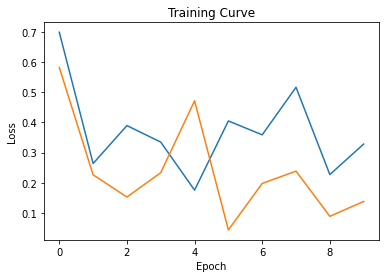

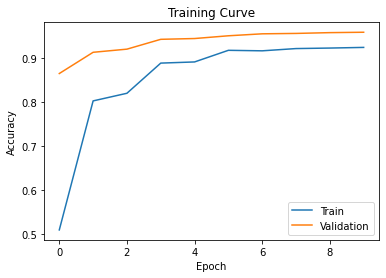

Training Accuracy: 0.9250538882440723
Validation Accuracy: 0.9596412556053812


In [36]:
# 2
model = RNN(len(text_field.vocab.itos), 200, 2)
train_rnn_network(model, train, valid, batch_size = 32, num_epochs = 10, learning_rate = 5e-5)

In [39]:
class RNN_2(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        self.name = "RNN_2"
        super(RNN_2, self).__init__()
        self.emb = torch.eye(len(text_field.vocab.itos))
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # Look up the embedding
        x = self.emb[x]
        # Set an initial hidden state
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        # Forward propagate the RNN
        out, _ = self.rnn(x, h0)
        # Pass the output of the last time step to the classifier
        out = self.fc(torch.max(out, dim=1)[0])
        return out

Epoch 1; Loss 0.635819; Train Acc 0.499751; Val Acc 0.869058
Epoch 2; Loss 0.495102; Train Acc 0.481181; Val Acc 0.866368
Epoch 3; Loss 0.287651; Train Acc 0.908473; Val Acc 0.955157
Epoch 4; Loss 0.237454; Train Acc 0.898193; Val Acc 0.973094
Epoch 5; Loss 0.286743; Train Acc 0.954071; Val Acc 0.944395
Epoch 6; Loss 0.085114; Train Acc 0.906815; Val Acc 0.978475
Epoch 7; Loss 0.066541; Train Acc 0.915934; Val Acc 0.977578
Epoch 8; Loss 0.141756; Train Acc 0.910131; Val Acc 0.978475
Epoch 9; Loss 0.049381; Train Acc 0.930028; Val Acc 0.978475
Epoch 10; Loss 0.208403; Train Acc 0.918256; Val Acc 0.978475


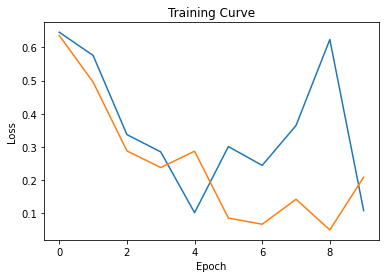

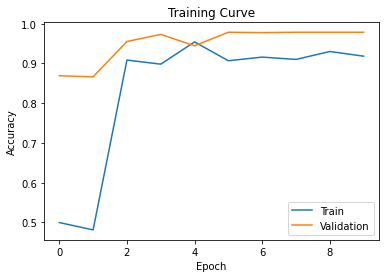

Training Accuracy: 0.9182556789918753
Validation Accuracy: 0.97847533632287


In [40]:
# 3
model = RNN_2(len(text_field.vocab.itos), 200, 2)
train_rnn_network(model, train, valid, batch_size = 32, num_epochs = 10, learning_rate = 5e-5)

Epoch 1; Loss 1.545272; Train Acc 0.496269; Val Acc 0.868161
Epoch 2; Loss 0.476697; Train Acc 0.614492; Val Acc 0.884305
Epoch 3; Loss 0.089355; Train Acc 0.804344; Val Acc 0.935426
Epoch 4; Loss 0.087114; Train Acc 0.872658; Val Acc 0.947982
Epoch 5; Loss 0.464986; Train Acc 0.648980; Val Acc 0.800000
Epoch 6; Loss 0.142789; Train Acc 0.905986; Val Acc 0.973991
Epoch 7; Loss 0.297373; Train Acc 0.923727; Val Acc 0.928251
Epoch 8; Loss 0.156981; Train Acc 0.935334; Val Acc 0.968610
Epoch 9; Loss 0.188754; Train Acc 0.934008; Val Acc 0.964126
Epoch 10; Loss 0.033181; Train Acc 0.839662; Val Acc 0.930045
Epoch 11; Loss 2.411839; Train Acc 0.716299; Val Acc 0.722870
Epoch 12; Loss 1.656011; Train Acc 0.660255; Val Acc 0.914798
Epoch 13; Loss 0.372390; Train Acc 0.933013; Val Acc 0.975785
Epoch 14; Loss 0.295407; Train Acc 0.817941; Val Acc 0.911211
Epoch 15; Loss 0.061282; Train Acc 0.914442; Val Acc 0.966816


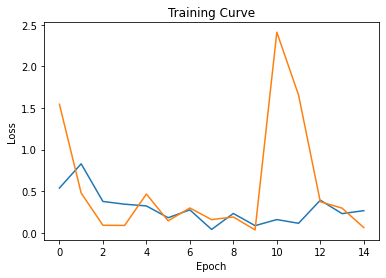

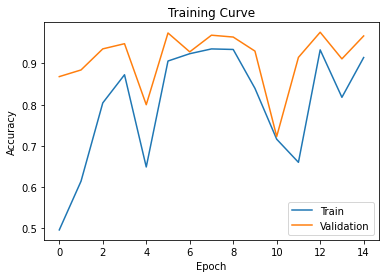

Training Accuracy: 0.9144420494113745
Validation Accuracy: 0.9668161434977578


In [41]:
# 4
model = RNN(len(text_field.vocab.itos), 200, 2)
train_rnn_network(model, train, valid, batch_size = 64, num_epochs = 15, learning_rate = 5e-4)

### Part (d) [2 pt]

Before we deploy a machine learning model, we usually want to have a better understanding
of how our model performs beyond its validation accuracy. An important metric to track is
*how well our model performs in certain subsets of the data*.

In particular, what is the model's error rate amongst data with negative labels?
This is called the **false positive rate**.

What about the model's error rate amongst data with positive labels?
This is called the **false negative rate**.

Report your final model's false positive and false negative rate across the
validation set.

In [45]:
# Create a Dataset of only spam validation examples
valid_spam = torchtext.legacy.data.Dataset(
    [e for e in valid.examples if e.label == 1],
    valid.fields)
# Create a Dataset of only non-spam validation examples
valid_nospam = torchtext.legacy.data.Dataset(
    [e for e in valid.examples if e.label == 0],
    valid.fields)

best_model = RNN_2(len(text_field.vocab.itos), 200, 2)
best_model_path = "model_{0}_bs{1}_lr{2}_epoch{3}".format("RNN", 64, 5e-4, 14)
state = torch.load(best_model_path)
best_model.load_state_dict(state)


FP_rate = 1 - get_accuracy(best_model, 32, valid_nospam)
FN_rate = 1 - get_accuracy(best_model, 32, valid_spam)

print("False positive rate:", FP_rate)
print("False negative rate:", FN_rate)



False positive rate: 0.007253886010362698
False negative rate: 0.23333333333333328


### Part (e) [2 pt]

The impact of a false positive vs a false negative can be drastically different.
If our spam detection algorithm was deployed on your phone, what is the impact
of a false positive on the phone's user? What is the impact of a false negative?

In [46]:
# False positive: a spam message is classified as non-spam. 
# FP impact: still getting spam messages even with filter

# False negative: a non-spam message is classified as spam. 
# FN impact: missing useful and important messages.

## Part 4. Evaluation [11 pt]

### Part (a) [1 pt]

Report the final test accuracy of your model.

In [48]:
test_accuracy = get_accuracy(best_model, 32, test)
print("Test Accuracy:", test_accuracy)

Test Accuracy: 0.9712746858168761


### Part (b) [3 pt]

Report the false positive rate and false negative rate of your model across the test set.

In [50]:
# Create a Dataset of only spam test examples
test_spam = torchtext.legacy.data.Dataset(
    [e for e in test.examples if e.label == 1],
    test.fields)
# Create a Dataset of only non-spam test examples
test_no_spam = torchtext.legacy.data.Dataset(
    [e for e in test.examples if e.label == 0],
    test.fields)

FP_rate = 1 - get_accuracy(best_model, 32, test_no_spam)
FN_rate = 1 - get_accuracy(best_model, 32, test_spam)

print("False positive:", FP_rate)
print("False negative:", FN_rate)

False positive: 0.002072538860103612
False negative: 0.20134228187919467


### Part (c) [3 pt]

What is your model's prediction of the **probability** that
the SMS message "machine learning is sooo cool!" is spam?

Hint: To begin, use `text_field.vocab.stoi` to look up the index
of each character in the vocabulary.

In [52]:
msg = "machine learning is sooo cool!"
# print(text_field.vocab.stoi)

msg_list = []
for i in range(len(msg)):
    msg_list.append(text_field.vocab.stoi[msg[i]])

test_msg = torch.LongTensor([msg_list])
prediction = best_model(test_msg)
spam_prob = np.exp(float(prediction[0][1])) / (np.exp(float(prediction[0][0])) + np.exp(float(prediction[0][1])))
print("Probability of spam:", spam_prob)

Probability of spam: 0.16767417170949006


### Part (d) [4 pt]

Do you think detecting spam is an easy or difficult task?

Since machine learning models are expensive to train and deploy, it is very
important to compare our models against baseline models: a simple
model that is easy to build and inexpensive to run that we can compare our
recurrent neural network model against.

Explain how you might build a simple baseline model. This baseline model
can be a simple neural network (with very few weights), a hand-written algorithm,
or any other strategy that is easy to build and test.

**Do not actually build a baseline model. Instead, provide instructions on
how to build it.**

In [54]:
# I think it is not very easy to detect spam, because it's too risky to classify a message as spam if certain words
# appears multiple times.
# To build a baseline model, we can simply calaulate the number of occurances of suspicious words in a message.
# We can have a list for suspicious words.
# If the returned number is too larger, then it is likely that the message is a spam.